In [1]:
import requests, json


def current_location():
    here_req = requests.get("http://www.geoplugin.net/json.gp")

    if here_req.status_code != 200:
        print("현재좌표를 불러올 수 없음")
    else:
        location = json.loads(here_req.text)
        crd = {
            "lat": str(location["geoplugin_latitude"]),
            "lng": str(location["geoplugin_longitude"]),
        }

    return crd


crd = current_location()
print(crd)

{'lat': '35.1893', 'lng': '128.0843'}


In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from pyproj import Transformer

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

transformer = Transformer.from_crs("epsg:5186", "epsg:4326", always_xy=True)


def transform_geometry(geom):
    if geom.geom_type == "Polygon":
        exterior_coords = list(geom.exterior.coords)
        transformed_coords = Polygon(
            [transformer.transform(x, y) for x, y in exterior_coords]
        )
        return transformed_coords


gdf = gpd.read_file("./datasets/BND_ADM_DONG_PG.shp", geometry="geometry")
gdf = gdf[gdf["ADM_CD"].str.startswith("1")]
gdf["geometry"] = gdf["geometry"].apply(transform_geometry)
gdf.crs = "epsg:4326"

c:\Users\MoonDongWon\anaconda3\envs\jsj\lib\site-packages\pyogrio\core.py:35: RuntimeWarning: Could not detect GDAL data files.  Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()
c:\Users\MoonDongWon\anaconda3\envs\jsj\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option GEOMETRY
  return ogr_read(


In [2]:
rest = pd.read_csv("./datasets/서울시 무더위쉼터.csv", encoding="euc-kr")
rest["Point"] = rest.apply(lambda row: Point(row["경도"], row["위도"]), axis=1)
rest = gpd.GeoDataFrame(rest, geometry="Point")
rest.crs = "epsg:4326"

C:\Users\MoonDongWon\AppData\Roaming\Python\Python310\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


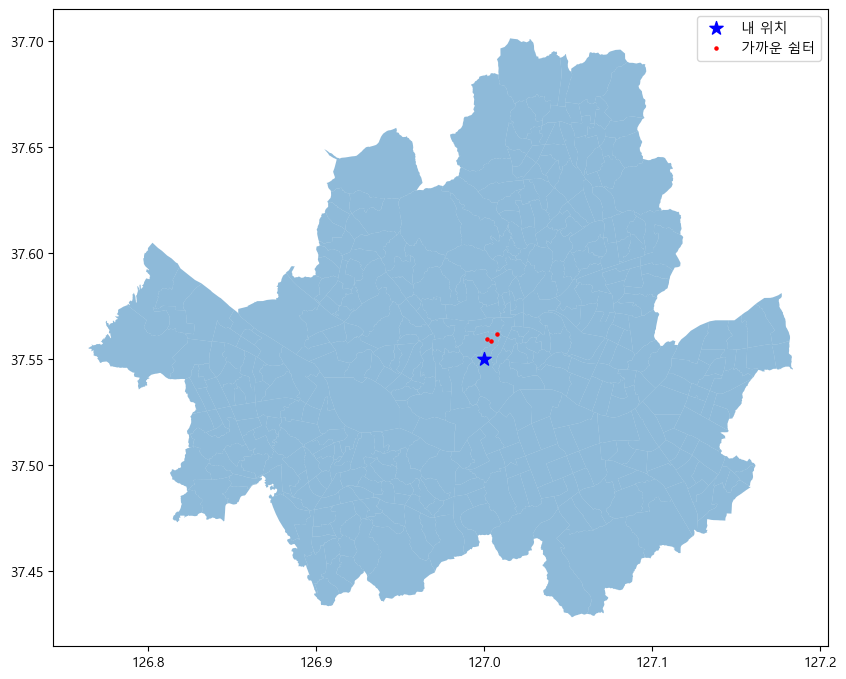

In [9]:
temperature = 35
my_gps = Point(127, 37.55)
count = 5

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# 행정동 경계 그리기
gdf.plot(ax=ax, alpha=0.5)

# 내 위치 표시
ax.scatter(my_gps.x, my_gps.y, color="blue", s=100, marker="*", label="내 위치")

if temperature > 32:
    # 내 위치가 속한 행정동 찾기
    my_dong = gdf[gdf.geometry.contains(my_gps)].iloc[0]

    # 같은 행정동에 있는 쉼터만 필터링
    local_rest = rest[rest.geometry.within(my_dong.geometry)]

    # 실제 도로 네트워크를 기반으로 거리 계산
    import osmnx as ox
    import networkx as nx

    # 도로 네트워크 다운로드
    G = ox.graph_from_polygon(my_dong.geometry, network_type="walk")

    # 내 위치와 쉼터들의 최단 경로 거리 계산
    distances = []
    for idx, shelter in local_rest.iterrows():
        orig_node = ox.nearest_nodes(G, my_gps.x, my_gps.y)
        dest_node = ox.nearest_nodes(G, shelter.Point.x, shelter.Point.y)
        try:
            distance = nx.shortest_path_length(G, orig_node, dest_node, weight="length")
            distances.append(distance)
        except:
            distances.append(float("inf"))

    # 가장 가까운 쉼터 선택
    local_rest["real_distance"] = distances
    nearest_rest = local_rest.nsmallest(count, "real_distance")

    # 가까운 쉼터 표시
    nearest_rest.plot(ax=ax, color="red", markersize=5, label="가까운 쉼터")

plt.legend()
plt.show()